In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
from scipy import integrate
from scipy.interpolate import interp1d
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 1\Optical eff measurements\Tom')

Note- The code to find the external efficiency is very similar however doesn't take into account of the fraction of photons absorbed and just uses the number of photons from the light source.

# Function to find fraction of photons absorbed

In [7]:
def fractions_of_photons_abs(A, g):
    fopa=1-(10**(-A*g))
    return fopa


# Function to find the number of photons emitted at an edge from the power spectrum

I've just used trapezium rule here- could also use simposon's rule and this may give you a better value

In [8]:
def num_photons(micro_W_per_nm, x):
    '''Function that returns the number of photons from a spectrum recorded in micro_W_per_nm, using the trapezium rule for integration.'''
    array_W_per_m = micro_W_per_nm*((10**(-6))*(10**(9)))  # Convert microW/nm to W/m
    #print(averaged_array_W_per_m)
    array_W = array_W_per_m*(x*(10**(-9)))  # Multiply by recorded wavelength at each power spectrum
    #print(averaged_array_W)
    h= 6.626*(10**(-34))
    c= 3.0*(10**(8))
    array_to_integrate = array_W/(h*c)# Devide by h*c
    #print(array_to_integrate)
    simp_photons_per_s = integrate.simpson(array_to_integrate, x=x) #Simpson's rule
    np_trapz_photons_per_s= np.trapz(array_to_integrate, x=x)
    return(np_trapz_photons_per_s)

# Function to find the number of photons that are absorbed into LSC

Similar to function above (takes power spectrum of input) but also considers fraction of photons absrobed (fopa)

In [9]:
def num_photons_fopa_adjusted(micro_W_per_nm,fopa, x):
    '''Function that returns the number of photons from a spectrum recorded in micro_W_per_nm, using the trapezium rule for integration.'''
    array_W_per_m = micro_W_per_nm*((10**(-6))*(10**(9)))  # Convert microW/nm to W/m
    #print(averaged_array_W_per_m)
    array_W = array_W_per_m*(x*(10**(-9)))  # Multiply by recorded wavelength at each power spectrum
    #print(averaged_array_W)
    h= 6.626*(10**(-34))
    c= 3.0*(10**(8))
    num_photons_func_of_wl = array_W/(h*c)      # Devide by h*c
    array_to_integrate=num_photons_func_of_wl*fopa
    simp_photons_per_s = integrate.simpson(array_to_integrate, x=x)
    np_trapz_photons_per_s= np.trapz(array_to_integrate, x=x)
    sp_trapz_photons_per_s= integrate.trapezoid(array_to_integrate, x=x)
    return(np_trapz_photons_per_s)

# Calculate the internal efficiency for each edge and printing pattern

In [10]:
column_names = ["Filename", "Int Eff", "Adjusted photons in", "Photons out"]
int_eff_df = pd.DataFrame(columns = column_names)
undoped_int_eff_df = pd.DataFrame(columns = column_names)
printing_patterns= ['ZZ', 'AZZ', 'Conc','AZZoffset45', 'Bulk']
grouped_data_eff= np.empty([0,3])
undoped_grouped_data_eff= np.empty([0,3])


for k in range(len(printing_patterns)):         # Iterate over printing patterns


    #%% Caluate fopa for photons in for each printing pattern using UV/Vis data
    os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 1\UV-Vis\2022-01-12\plottable\Doped')
    filename = printing_patterns[k]+".WDATA"
    col = ["Wl","A"]
    df = pd.read_csv(filename, sep=",", names=col)           #Import UV/Vis data
    df = df.iloc[240:-99,:]    #Only take values from 800-350nm
    df = df.iloc[::-1]       #Reverse df
    f= interp1d(df['Wl'].to_numpy().astype(float),df['A'].to_numpy().astype(float))     #Need to interpolate as UV/Vis doesn't give data in steps of 1
    xnew = np.linspace(350, 800, num=451, endpoint=True)
    fopa = fractions_of_photons_abs(f(xnew), 1)         #Anne included a geometric factor on the this to account for differences in thickness- I don't think this is needed

    #%% Calculate photos in from power spectrum 
    os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 1\Optical eff measurements\Tom') 
    ls_all=np.empty([1,3])
    # Import
    for i in range(3):
        lightsource_filename = "19.01\Light source\ls"+str(i+1)+".xls"
        lightsource_df = pd.read_csv(lightsource_filename, sep='\t')
        lightsource_df = lightsource_df.iloc[109:560,:]         #Want values between 350 and 800 for wl
        print(lightsource_df)
        lightsource_array = lightsource_df.to_numpy()
        lightsource_array = lightsource_array.astype(float)
        lightsource_wl=lightsource_array[:,0]
        lightsource_micro_W_per_nm= lightsource_array[:,1]
        photons_in = num_photons_fopa_adjusted(lightsource_micro_W_per_nm,fopa, lightsource_wl)
        ls_all[0,i]= photons_in #put p in into one array  
        
    ave_photons_in=np.mean(ls_all,axis=1)

    
    
    
    for j in range(4):              #Iterate over all sides of the LSC
    
        ##      Import data
        
        filename = '19.01\\'+printing_patterns[k]+ r'\Doped\\'+printing_patterns[k]+'_side' +str(j+1)+ '.xls'
         
        
        
        total_array = np.empty([451,0])  #Make an empty array we can put the data in
        
        
        for i in range(3):  #Iterate over 3 runs to find the standard deviation
            #print(filename)
            current_df = pd.read_csv(filename, sep='\t')
            #print(current_df)
            current_df = current_df.iloc[109:560,:]   #Only take data between 350 and 800
            current_array = current_df.to_numpy()
            current_array = current_array.astype(float)
            total_array= np.append(total_array,current_array, axis =1)  #append current array onto total array
            if i>0: # Reset file name if not on first loop
                filename= filename[:-6]+filename[-4:]
            filename = filename[:-4]+"_"+str(i+1)+filename[-4:]

        x= total_array[:,0]
        pre_average= np.delete(total_array,np.s_[::2], 1)# delete wl
        all_runs=np.empty([1,3])
        for l in range(3):
            all_runs[0,l] = num_photons(pre_average[:,l], x)        # put all 3 runs in one array once found num_photons
        #print(all_runs)
        sd = np.std(all_runs[:])   # calculate sd of all 3 runs
        
    
        
        
        
        ## Calculate Int Eff- Single edge
        shape_factor= (0.0125*0.0127)/((math.pi)*((0.01)**2))
        adjusted_photons_in= ave_photons_in*shape_factor 
        int_eff= (all_runs/adjusted_photons_in)*100
        grouped_data_eff= np.append(grouped_data_eff,int_eff)   #so that can group the data into printing patterns
        mean_int_eff= np.mean(int_eff)
        sd= (sd/adjusted_photons_in)*100
        int_eff_df= int_eff_df.append({'Filename':printing_patterns[k]+str(j+1),'Int Eff':mean_int_eff, 'Adjusted photons in':adjusted_photons_in,'SD':sd,'Photons out':np.mean(all_runs)}, ignore_index=True)

grouped_data_eff=np.reshape(grouped_data_eff,(5,12))    #group by printing pattern for later


    Scan Averages          10
109    350.000000   39.185188
110    351.000000   41.203890
111    352.000000   39.742074
112    353.000000   40.290240
113    354.000000   40.898027
..            ...         ...
555    796.000000  209.105051
556    797.000000  228.452385
557    798.000000  241.757575
558    799.000000  241.843598
559    800.000000  222.876162

[451 rows x 2 columns]
    Scan Averages          10
109    350.000000   38.775067
110    351.000000   39.723424
111    352.000000   37.093884
112    353.000000   40.546929
113    354.000000   41.068436
..            ...         ...
555    796.000000  210.971099
556    797.000000  219.855494
557    798.000000  241.090248
558    799.000000  241.243443
559    800.000000  215.405558

[451 rows x 2 columns]
    Scan Averages          10
109    350.000000   40.005430
110    351.000000   41.304504
111    352.000000   39.895871
112    353.000000   39.697882
113    354.000000   40.347851
..            ...         ...
555    796.000000  212

# Group the sides depending on printing pattern, then plot

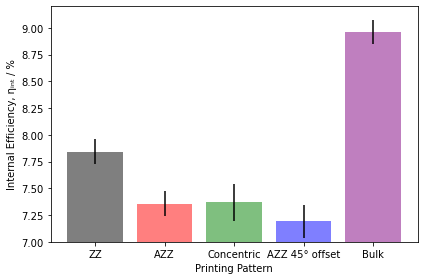

In [11]:
grouped_df = pd.DataFrame(columns = ['Printing Pattern','Int_eff','SD'])    
grouped_df=grouped_df.set_index('Printing Pattern')
grouped_data_by_edge=np.empty([5,1])
#Find the standard deviation for each printinging pattern by taking the sqrt of the summed variances
sd_from_grouped= np.empty([5,1])
summed_squared= np.empty([5,1])
sd_for_each_pp = int_eff_df['SD']
sd_for_each_pp= np.stack(sd_for_each_pp)
sd_for_each_pp = np.split(sd_for_each_pp,5)
sd_for_each_pp= np.square(sd_for_each_pp)
for i in range(5):
    summed_squared[i] = sum(sd_for_each_pp[i])
sd_by_pp= np.sqrt(summed_squared)


for i in range(5):
    edge_ave= np.empty([4,1])
    
    for j in range(4):
        edge_ave[j] = np.mean(grouped_data_eff[i][(3*j):((3*(j+1)))])   #Find the mean for each edge from the 'grouped_data_eff from the previous cell'
        
    grouped_df = grouped_df.append({'Printing Pattern':printing_patterns[i],'Int_eff':sum(edge_ave),'SD':sd_by_pp[i]},ignore_index=True)

bar_colours=['black']+['red']+['green']+['blue']+['purple']
fig1,ax1=plt.subplots()
locs, labels = plt.xticks()
plt.xticks([0,1,2,3,4],['ZZ', 'AZZ', 'Concentric','AZZ 45'+u'\N{DEGREE SIGN}'' offset', 'Bulk'])
bars1=ax1.bar(grouped_df['Printing Pattern'], grouped_df['Int_eff'].to_numpy().astype(float), yerr =grouped_df['SD'].to_numpy().astype(float),align='center', ecolor='black',color=bar_colours,alpha=0.5)
plt.xlabel('Printing Pattern')
plt.ylabel('Internal Efficiency, '+'\u03B7\u1D62\u2099\u209C' +' / %')
plt.ylim(7,9.2)
plt.tight_layout()
plt.show()
#plt.savefig('Doped Internal Eff per printing pattern.png',dpi=(1000))